<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B6%5D_ODE_PINN_finite_difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Credits : Mahmoud Asem @Asem000

In [ ]:
#Imports
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax

In [ ]:
import sympy as sp

### Generate a a differential equation and its solution using SymPy

In [ ]:
t= sp.symbols('t')
f = sp.Function('y')
diffeq = sp.Eq(f(t).diff(t,t) + f(t).diff(t)-t*sp.cos(2*sp.pi*t),0)
sol = sp.simplify(sp.dsolve(diffeq,ics={f(0):1,f(t).diff(t).subs(t,0):10}).rhs)

In [ ]:
diffeq

Eq(-t*cos(2*pi*t) + Derivative(y(t), t) + Derivative(y(t), (t, 2)), 0)

In [ ]:
sp.Eq(f(t).diff(t).subs(t,0),10)

Eq(Subs(Derivative(y(t), t), t, 0), 10)

In [ ]:
sp.Eq(f(t).subs(t,0),1)

Eq(y(0), 1)

In [ ]:
sp.Eq(f(t),sol)

Eq(y(t), (2*pi*t*exp(t)*sin(2*pi*t) + 8*pi**3*t*exp(t)*sin(2*pi*t) - 16*pi**4*t*exp(t)*cos(2*pi*t) - 4*pi**2*t*exp(t)*cos(2*pi*t) + 16*pi**3*exp(t)*sin(2*pi*t) + exp(t)*cos(2*pi*t) + 12*pi**2*exp(t)*cos(2*pi*t) - exp(t) + 36*pi**2*exp(t) + 336*pi**4*exp(t) + 704*pi**6*exp(t) - 640*pi**6 - 304*pi**4 - 44*pi**2)*exp(-t)/(4*pi**2*(1 + 8*pi**2 + 16*pi**4)))

In [ ]:
#verify solution
sp.simplify(-t*sp.cos(sp.pi*2*t)+sol.diff(t)+sol.diff(t,t))

0

### Constructing the MLP

In [ ]:
N_b = 1
N_c = 100

tmin,tmax=0. ,jnp.pi

'''boundary conditions'''


# U[0] = 1
t_0 = jnp.ones([N_b,1],dtype='float32')*0.
ic_0 = jnp.ones_like(t_0) 
IC_0 = jnp.concatenate([t_0,ic_0],axis=1)

# U_t[0] = 10
t_b1 = jnp.zeros([N_b,1])
bc_1 = jnp.ones_like(t_b1) * 10
BC_1 = jnp.concatenate([t_b1,bc_1],axis=1)

conds = [IC_0,BC_1]

#collocation points

key=jax.random.PRNGKey(0)

t_c = jnp.linspace(tmin,tmax,N_c).reshape(-1,1)
colloc = t_c

def ODE_loss(t,u):
  dt = 0.03173326
  u_t = lambda t: (-u(t+2*dt)+8*u(t+dt)-8*u(t-dt)+u(t-2*dt))/(12*dt)
  u_tt = lambda t: (-u(t+2*dt) + 16*u(t+dt) -30*u(t) + 16 * u(t-dt) - u(t-2*dt))/(12*dt**2)
  return -t*jnp.cos(2*jnp.pi*t) + u_t(t) + u_tt(t)

In [ ]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)

def loss_fun(params,colloc,conds):
  t_c =colloc[:,[0]]
  ufunc = lambda t : fwd(params,t)
  ufunc_t=lambda t:jax.grad(lambda t:jnp.sum(ufunc(t)))(t)
  loss =jnp.mean(ODE_loss(t_c,ufunc) **2)

  t_ic,u_ic = conds[0][:,[0]],conds[0][:,[1]]  
  loss += MSE(u_ic,ufunc(t_ic))

  t_bc,u_bc = conds[1][:,[0]],conds[1][:,[1]]  
  loss += MSE(u_bc,ufunc_t(t_bc))

  return  loss

@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)
  
  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  #Update params
  # return jax.tree_multimap(lambda params,grads : params-LR*grads, params,grads)
  return opt_state,params


In [ ]:
# construct the MLP of  6 hidden layers of 8 neurons for each layer
params = init_params([1] + [20]*4+[1])

In [ ]:
lr = optax.piecewise_constant_schedule(1e-3,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

In [ ]:
%%time
epochs = 100_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(1000) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=1.026e+02
Epoch=1000	loss=1.134e+01
Epoch=2000	loss=7.139e+00
Epoch=3000	loss=4.549e+00
Epoch=4000	loss=2.824e+00
Epoch=5000	loss=2.343e+00
Epoch=6000	loss=2.147e+00
Epoch=7000	loss=1.904e+00
Epoch=8000	loss=1.563e+00
Epoch=9000	loss=1.016e+00
Epoch=10000	loss=9.470e-01
Epoch=11000	loss=9.235e-01
Epoch=12000	loss=9.041e-01
Epoch=13000	loss=8.905e-01
Epoch=14000	loss=8.731e-01
Epoch=15000	loss=8.661e-01
Epoch=16000	loss=8.594e-01
Epoch=17000	loss=8.494e-01
Epoch=18000	loss=8.424e-01
Epoch=19000	loss=8.380e-01
Epoch=20000	loss=8.348e-01
Epoch=21000	loss=8.259e-01
Epoch=22000	loss=8.208e-01
Epoch=23000	loss=8.104e-01
Epoch=24000	loss=8.035e-01
Epoch=25000	loss=7.996e-01
Epoch=26000	loss=7.991e-01
Epoch=27000	loss=7.855e-01
Epoch=28000	loss=7.851e-01
Epoch=29000	loss=7.818e-01
Epoch=30000	loss=7.784e-01
Epoch=31000	loss=7.729e-01
Epoch=32000	loss=7.824e-01
Epoch=33000	loss=7.703e-01
Epoch=34000	loss=7.798e-01
Epoch=35000	loss=7.726e-01
Epoch=36000	loss=7.629e-01
Epoch=37000	lo

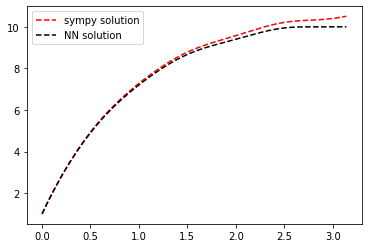

In [ ]:
lam_sol= sp.lambdify(t,sol)

dT = 1e-3
Tf = jnp.pi
T = np.arange(0,Tf+dT,dT)


sym_sol =np.array([lam_sol(i) for i in T])

plt.plot(T,sym_sol,'--r',label='sympy solution')
plt.plot(T,fwd(params,T.reshape(-1,1))[:,0],'--k',label='NN solution')
plt.legend()